In [95]:
import numpy as np
import pandas as pd

def one_hot_encoding(y, n_classes):
    one_hot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y):
        one_hot[val, idx] = 1
    return one_hot.T


def sigmoid_activation_function(weighted_input):
    return 1/(1 + np.exp(-weighted_input))


def sigmoid_activation_function_derivative(activated):
    return activated * (1. - activated)


class Layer:
    def __init__(self, input_nodes, output_nodes):
        self.output_nodes = output_nodes
        random = np.random.RandomState(1)
        self.weights = random.normal(
            loc=0.0, scale=0.1, size=(input_nodes, output_nodes))
        self.bias_values = np.ones(output_nodes)

    def forward_propagation(self, input_values):
        self.input_values = input_values
        output_values = np.dot(input_values, self.weights) + self.bias_values
        self.z = output_values
        activation_values = sigmoid_activation_function(output_values)
        self.a = activation_values

        return activation_values

    def update_gradients(self, delta_weight, delta_bias):
        self.delta_weight = delta_weight
        self.delta_bias = delta_bias

    def update_params(self, learning_rate):
        self.weights -= self.delta_weight * learning_rate
        self.bias_values -= self.delta_bias * learning_rate


class NeuralNetwork:
    def __init__(self, layer_sizes, epochs, learning_rate=1e-3):
        self.layers = [Layer(layer_sizes[layer_number], layer_sizes[layer_number + 1])
                       for layer_number in range(len(layer_sizes) - 1)]
        self.errors = []
        self.epochs = epochs
        self.learning_rate = learning_rate

    def forward_propagation(self, input_values):
        for layer in self.layers:
            input_values = layer.forward_propagation(input_values)

        return input_values

    def network_predict(self, X):
        activation_values = self.forward_propagation(X)
        predictions = np.argmax(activation_values, axis=1)

        return predictions

    def network_loss(self, y, y_predicted):
        return np.sum(0.5*(y_predicted - y)**2, axis=1).mean()

    def update_all_gradients(self, y, y_predict):
        output_layer = self.layers[-1]
        delta = (y_predict - y) * \
            sigmoid_activation_function_derivative(output_layer.a)
        delta_weight = np.dot(output_layer.input_values.T, delta)
        delta_bias = np.mean(delta, axis=0)
        output_layer.update_gradients(delta_weight, delta_bias)

        for i in range(-2, -len(self.layers) - 1, -1):
            delta = np.dot(delta, self.layers[i+1].weights.T) * \
                sigmoid_activation_function_derivative(self.layers[i].a)
            delta_weight = np.dot(self.layers[i].input_values.T, delta)
            delta_bias = np.mean(delta, axis=0)
            self.layers[i].update_gradients(delta_weight, delta_bias)

        for layer in self.layers:
            layer.update_params(self.learning_rate)

    def learn(self, input_data, labels):
        encoded_labels = one_hot_encoding(
            labels, self.layers[len(self.layers)-1].output_nodes)
        for i in range(self.epochs):
            predicted_labels = self.forward_propagation(input_data)
            self.update_all_gradients(encoded_labels, predicted_labels)
            self.errors.append(self.network_loss(
                encoded_labels, predicted_labels))

# Testing with iris dataset

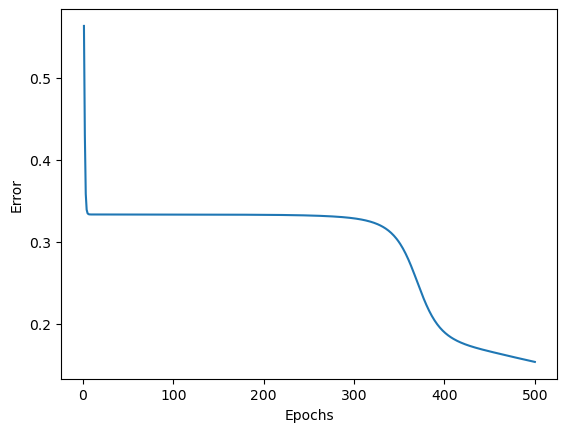

In [97]:
import matplotlib.pyplot as plt
iris_data = pd.read_csv('https://archive.ics.uci.edu/ml/''machine-learning-databases/iris/iris.data')

def map_name_to_value(iris_name):
    if 'Iris-virginica' == iris_name:
        return 2
    elif 'Iris-versicolor' == iris_name:
        return 1
    elif 'Iris-setosa' == iris_name:
        return 0
    
    return -1 

labels = np.array([map_name_to_value(iris_name) for iris_name in iris_data.iloc[0:150, 4].values])
input_values = iris_data.iloc[0:150, [0, 1, 2, 3]].values

layers = [4, 10, 10, 3]
network = NeuralNetwork(layer_sizes=layers, epochs=500, learning_rate=0.01)
network.learn(input_values, labels)

plt.plot(range(1, len(network.errors)+1), network.errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()